In [1]:
%matplotlib inline
import matplotlib.pylab as plt
plt.style.use(['bmh'])
import pandas as pd
import re, sys
import numpy as np
pd.options.display.max_colwidth = 500

In [2]:
class TextProcessor(object):

    def __init__(self, lemmatize=False, stopwords_files=None, names=set()):
        self.lemmatize = lemmatize
        if lemmatize:
            from pymystem3 import Mystem
            self.m = Mystem()

        self.stopwords = set()
        if stopwords_files:
            for file in stopwords_files:
                with open(file) as f:
                    stop = map(lambda l: l.rstrip(), f)
                    self.stopwords.update(stop)

        self.names = names
        self.word_re = re.compile(r'[ёа-я]+(?:-?[ёа-я_]+(?:[ёа-я]+)?)?')
        self.pref_re = re.compile(r'\b(не|ни|нет|без) (\w+)')

    def convert(self, text):
        text = text.rstrip().lower()
        text = self.pref_re.sub(r'\1_\2', text)
        words = self.word_re.findall(text)

        if self.lemmatize:
            text = ''.join(self.m.lemmatize(' '.join(words)))
            words = text.split()

        words = [x for x in words
                     if x not in self.names
                     and x not in self.stopwords
                     and len(x) > 1]
        
        return ' '.join(words)

In [3]:
# prc = TextProcessor(lemmatize=True, stopwords_files=['russian.txt'], names=names)
# test = '''Вопрос/проблема: Невозможно создать сделку по ЗП по Клиенту ООО ""БЕРЛИНД
#         БРЕНД"" ИНН 7611998995 , отсутствует MDM ID С уважением, Кучерова Наталия
#         Владимировна Ассистент клиентского менеджера Северный банк Ярославское отделение
#         № 0017 Управление продаж малому бизнесу Размещение : пр-т Ленина д.25 Телефон :
#         0 вн. : 8-58-61-2207'''
# prc.convert(test)

### Загрузка данных и очистка от лишних сущностей

In [4]:
data = pd.read_excel('Закрыто Март.xlsx')
data = data[['Суть вопроса','Информация']]
data['Суть вопроса'] = data['Суть вопроса'].fillna('')
data['text'] = data['Суть вопроса'] + ' ' + data['Информация']
data['text'] = data['text'].apply(lambda x: ' '.join(x.split()))
data = data[['text']]
print(data.shape)
data.head()

(30182, 1)


,text
0,"Добрый день! В CRM корпоративном при создании обращения, некорректно прилагаются вложения, например: при регистрации обращения, сначала вложение прикрепляются корректно, но после регистрации последующих обращений, предыдущие обращения слетают или прикрепляются вложения других обращений. Ошибка во вложении. При возникновении дополнительных вопросов обращайтесь по телефону 8-613-2011. Нестандартный ЗНО"
1,"Вопрос/проблема: мной было зарегистрировано обращение 180215-0070-425100в нем не должно было быть вложений , к нему было подтянуто вложение с другого обращения"
2,"ранее я оставляла обращение по поводу прикрепленных файлов в CRM корпоративный- SD49605571, сотрудник рассматривающий мое обращение порекомендовал мне задерживаться на вкладке прикрепления файлов на 3- 5 минут! Этот совет не работает! И я по прежнему вынуждена возвращаться в обработанные мною письма, искать файл и направлять назначенному исполнителю в CRM корпоративный. Прошу УСТРАНИТЬ ДАННУЮ ОШИБКУ!!!!"
3,"Вопрос/проблема: при закрытии Звонка с результатом Категорический отказ в Потенциальной продаже, звонок отменяется автоматически. 1-NJ2DX49 1-NJ2DX5B 1-NJ2DMMF 1-NJ2DME3"
4,закрыть сделку со статусом закрыта заключена 1-MII4MYS инн 4632236985 закрыть сделку со статусом закрыта заключена Нестандартный ЗНО


In [5]:
data.to_csv('texts.csv')

### Загрузка имен

In [6]:
names_ds = pd.read_csv('names.csv', index_col=0)
names_ds.head()

,score
word,
александровна,0.981651
владимировна,0.981985
николаевна,0.978030
елена,0.995344
александр,0.986966


In [7]:
names_ds = names_ds[~names_ds.index.str.contains('-')]
names_ds = names_ds[~names_ds.index.str.contains('/')]

In [8]:
names = set(names_ds[names_ds.score >= 0.8].index)

In [9]:
len(names)

859641

In [10]:
'наталия' in names

True

### Токенизация + лемматизация + удаление имен и стоп-слов

In [11]:
prc = TextProcessor(lemmatize=True, stopwords_files=['russian.txt'], names=names)
data['text'] = data['text'].apply(prc.convert)
data.head(10)

,text
0,добрый день корпоративный создание обращение некорректный прилагаться вложение регистрация обращение сначала вложение прикрепляться корректно регистрация последующий обращение предыдущий обращение слетать прикрепляться вложение обращение ошибка вложение возникновение дополнительный вопрос обращаться телефон нестандартный зно
1,вопрос проблема зарегистрировать обращение не_должно вложение подтянуто вложение обращение
2,ранее оставлять обращение повод прикреплять файл корпоративный сотрудник рассматривать обращение порекомендовать задерживаться вкладка прикрепление файл минута совет не_работать прежний вынужденный возвращаться обрабатывать письмо искать файл направлять назначать исполнитель корпоративный просить устранять данный ошибка
3,вопрос проблема закрытие звонок результат категорический отказ потенциальный продажа звонок отменяться автоматически
4,закрывать сделка статус закрывать заключать инн закрывать сделка статус закрывать заключать нестандартный зно
5,добрый день процесс тестирование сервис запрос документация организация государственный научный центр российский федерация исследовательский центр келдыш возникать следующий ошибка отсутствие получение файл клиент ответ запрос банк хронология работа сервис следующий создание запрос скриншот вложение отправка запрос клиент перевод статус стадия процесс скриншот вложение нажатие комбинация перевод статус стадия отправлять скриншот вложение нажатие комбинация перевод статус стадия доставлять ск...
6,вопрос проблема некорректный считаться срок стадия ввод данные сделка заемщик ооо балтойло трейд срок учитывать нерабочий день новогодний праздник приводить нарушение нормативный длительность срок сделка просить вносить изменение расчет срок стадия ввод данные
7,вопрос проблема выставление задача ас корпоративный компетенция пцп_цсрб операция кредитный продукт фл сотрудник вкладка экспертиза-на распределение не_отображаться выставлять задача задача находить поиск это взять работа либо вернуть доработка нет_возможность просить пояснять причина устранять ошибка пример задача
8,добрый день проблема корпоративный пользователь сотрудник ца должный подключаться разбор экспертиза наш площадка пцп цкр рц новосибирск это создавать отдельный компетенция ца_дивизионтранзакционный бизнес грантполучить данный компетенция добавлять весь настроенный корректно площадка пытаться отправлять экспертиза программа ругаться отсутствие сотрудник соответствующий компетенция прилагать переписка описание скриншот проблема
9,обращение клиент невозможно сделать вложение срочно заводить обращение ас друг не_принимать рассматривать отказывать нестандартный зно


In [12]:
data.to_csv('texts_limmatized.csv')

### Обучение биграммера

In [13]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.models import phrases

2018-04-15 22:51:12,384 : INFO : 'pattern' package not found; tag filters are not available for English


In [14]:
class MyCorpus(object):
    def __iter__(self):
        for row in data.itertuples():
            yield row[1].split()

In [15]:
corp = MyCorpus()
bigrams = phrases.Phrases(corp, min_count=12, threshold=5.0, scoring='default')
phraser = phrases.Phraser(bigrams)

2018-04-15 22:51:12,526 : INFO : collecting all words and their counts
2018-04-15 22:51:12,538 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-04-15 22:51:14,186 : INFO : PROGRESS: at sentence #10000, processed 180916 words and 31020 word types
2018-04-15 22:51:15,804 : INFO : PROGRESS: at sentence #20000, processed 353931 words and 48460 word types
2018-04-15 22:51:17,077 : INFO : PROGRESS: at sentence #30000, processed 528001 words and 62948 word types
2018-04-15 22:51:17,116 : INFO : collected 63169 word types from a corpus of 531055 words (unigram + bigrams) and 30182 sentences
2018-04-15 22:51:17,126 : INFO : using 63169 counts as vocab in Phrases<0 vocab, min_count=12, threshold=5.0, max_vocab_size=40000000>
2018-04-15 22:51:17,135 : INFO : source_vocab length 63169
2018-04-15 22:51:20,503 : INFO : Phraser built with 619 619 phrasegrams


### Сохранение биграм в файле для анализа

In [16]:
from itertools import groupby

out_dict = {phrase.decode('utf8').replace(' ','_'): score
    for phrase, score in bigrams.export_phrases(corp)}

bigram_array = [p.decode('utf8').replace(' ','_') for p, _ in bigrams.export_phrases(corp)]
bigram_count = {k: len(list(g)) for k, g in groupby(sorted(bigram_array))}

# Сохранить биграммы в файл
with open('bigrams.txt', 'w') as wp:
    for phrase in sorted(out_dict, key=out_dict.get, reverse=True):
        print('{:35} {:11.5f} {}'.format(phrase, out_dict[phrase], bigram_count[phrase]), file=wp)

### Применить биграмер к текстам

In [17]:
def bigram_transformer(text):
    words = phraser[text.split()]
    return ' '.join(words)

data['text'] = data['text'].apply(bigram_transformer)
data.head(10)

,text
0,добрый_день корпоративный создание обращение некорректный прилагаться вложение регистрация_обращение сначала вложение прикрепляться корректно регистрация последующий обращение предыдущий обращение слетать прикрепляться вложение обращение ошибка вложение возникновение дополнительный вопрос обращаться телефон нестандартный зно
1,вопрос_проблема зарегистрировать обращение не_должно вложение подтянуто вложение обращение
2,ранее оставлять обращение повод прикреплять файл корпоративный сотрудник рассматривать обращение порекомендовать задерживаться вкладка прикрепление файл минута совет не_работать прежний вынужденный возвращаться обрабатывать письмо искать файл направлять назначать исполнитель корпоративный просить устранять данный ошибка
3,вопрос_проблема закрытие звонок результат категорический_отказ потенциальный_продажа звонок отменяться автоматически
4,закрывать сделка статус закрывать_заключать инн закрывать сделка статус закрывать_заключать нестандартный зно
5,добрый_день процесс тестирование сервис запрос документация организация государственный научный центр российский федерация исследовательский центр келдыш возникать следующий ошибка отсутствие получение файл клиент ответ запрос банк хронология работа сервис следующий создание запрос скриншот_вложение отправка запрос клиент перевод статус стадия процесс скриншот_вложение нажатие комбинация перевод статус стадия отправлять скриншот_вложение нажатие комбинация перевод статус стадия доставлять ск...
6,вопрос_проблема некорректный считаться срок стадия_ввод данные сделка заемщик_ооо балтойло трейд срок учитывать нерабочий день новогодний праздник приводить нарушение нормативный длительность срок сделка просить вносить_изменение расчет срок стадия_ввод данные
7,вопрос_проблема выставление задача ас_корпоративный компетенция пцп_цсрб операция кредитный продукт фл сотрудник вкладка экспертиза-на распределение не_отображаться выставлять_задача задача находить поиск это взять_работа либо вернуть доработка нет_возможность просить пояснять причина устранять_ошибка пример задача
8,добрый_день проблема корпоративный пользователь сотрудник ца должный подключаться разбор экспертиза наш площадка пцп цкр рц новосибирск это создавать отдельный компетенция ца_дивизионтранзакционный бизнес грантполучить данный компетенция добавлять весь настроенный корректно площадка пытаться отправлять экспертиза программа ругаться отсутствие сотрудник соответствующий компетенция прилагать переписка описание скриншот проблема
9,обращение клиент невозможно сделать вложение срочно заводить обращение ас друг не_принимать рассматривать отказывать нестандартный зно


In [18]:
data.to_csv('texts_limm_bigram.csv')

### Сохранить в формате vowpal vabbit

In [19]:
from collections import Counter
vw_text_file = 'texts.vowpal-wabbit'
with open(vw_text_file, 'w') as f:
    for row in data.itertuples():
        words = row[1].split()
        freq = Counter(words)
        words = [term if cnt == 1 else '%s:%d' % (term, cnt) for term, cnt in freq.most_common()]
        print(row[0], ' '.join(words), file=f)

### Размеченные данные

In [20]:
data2 = pd.read_excel('Добавление в комманду список .xlsx')
data2 = data2[['Суть вопроса','Информация от инициатора','Процесс']]
data2['Суть вопроса'] = data2['Суть вопроса'].fillna('')
data2['Процесс'] = data2['Процесс'].fillna('')
data2['text'] = data2['Суть вопроса'] + ' ' + data2['Информация от инициатора']
data2['text'] = data2['text'].apply(lambda x: ' '.join(x.split()))
data2['Процесс'] = data2['Процесс'].apply(lambda x: ' '.join(x.split()))
data2 = data2[['text','Процесс']]
data2.columns = ['text','process']
data2.shape

(1211, 2)

In [21]:
data2.process.value_counts()

Смена ВКО, добавление в команду    866
                                   236
Прочее                              90
Задачи                              13
Договоры                             3
Смена статуса организации            2
Ведение оргструктуры (иерархия)      1
Name: process, dtype: int64

In [22]:
data2[['process','text']].to_csv('texts_labeled.csv', index_label='id_doc')

In [23]:
prc = TextProcessor(lemmatize=True, stopwords_files=['russian.txt'], names=names)
data2['text'] = data2['text'].apply(prc.convert)
data2['text'] = data2['text'].apply(bigram_transformer)

### Инициализация BigARTM

In [24]:
import artm
lc = artm.messages.ConfigureLoggingArgs()
lc.log_dir = '/tmp'
lib = artm.wrapper.LibArtm(logging_config=lc)
artm.version()

'0.9.0'

In [25]:
dir_batches = 'batches'
dict_file = 'dictionary.txt'
num_topics = 10
batch_size = 1000
document_passes   = 100
collection1_passes = 50
collection2_passes = 100
filter_dict = dict(min_tf=4, min_df=3)
num_tokens = 13
seed = 1

In [26]:
batch_vectorizer = artm.BatchVectorizer(
    data_path         = vw_text_file,
    data_format       = 'vowpal_wabbit',
    target_folder     = dir_batches,
    batch_size        = batch_size,
)
batch_vectorizer

artm.BatchVectorizer(data_path="batches", num_batches=31)

In [27]:
main_dict = artm.Dictionary()
main_dict.gather(dir_batches)
main_dict.filter(**filter_dict)
main_dict.save_text(dict_file)
main_dict

artm.Dictionary(name=e8ae4190-0724-4d28-914e-b4b2e5579d83, num_entries=2984)

### Словарь для "Смена ВКО"

In [28]:
import uuid
from math import log
data_c = data2.copy()

def make_dict_file(process, file_name, count_words=30):
    cc = Counter()
    for r in data_c[data_c.process == process].itertuples():
        cc.update(r[1].split())

    max_count = max(c for _, c in cc.most_common())
    cc_dict = {w: c/max_count+1 for w, c in cc.most_common(n=count_words)}

    w = open(file_name, 'w')
    with open(dict_file) as f:
        print('name: {} num_items: {}'.format(uuid.uuid1(), count_words), file=w)
        print('token, class_id, token_value, token_tf, token_df', file=w)
        for i, line in enumerate(f):
            if i <= 2: continue
            values = line.rstrip().split(', ')
            if values[0] in cc_dict:
                print('{}, {}, {}, {}, {}'.format(values[0], values[1],
                                                  cc_dict[values[0]],
                                                  values[3], values[4]), file=w)

In [210]:
make_dict_file('Смена ВКО, добавление в команду', 'dictionary_vko2.txt', 50)

In [211]:
vko_dict = artm.Dictionary()
vko_dict.load_text('dictionary_vko2.txt')
vko_dict

artm.Dictionary(name=7d44fbb1-36c0-4a5c-bd9b-29d7248e6cad, num_entries=50)

### Словарь для "Прочее"

In [223]:
make_dict_file('Прочее', 'dictionary_misc2.txt', 30)

In [224]:
misc_dict = artm.Dictionary()
misc_dict.load_text('dictionary_misc2.txt')
misc_dict

artm.Dictionary(name=5fda430e-76f9-4eb7-bf2b-76719000f459, num_entries=30)

### Словарь для "Задачи"

In [225]:
make_dict_file('Задачи', 'dictionary_task2.txt', 30)

In [226]:
task_dict = artm.Dictionary()
task_dict.load_text('dictionary_task2.txt')
task_dict

artm.Dictionary(name=b352acb7-7feb-4d2b-8886-98e3d06b6272, num_entries=30)

### Model ARTM

In [227]:
topics_vko = ['Смена ВКО']
topics_misc = ['Прочее']
topics_task = ['Задачи']
topics = ['Тема %d' % t for t in range(num_topics-3)]
topic_names = topics_vko + topics_misc + topics_task + topics

model = artm.ARTM(
    topic_names = topic_names,
    dictionary = main_dict,
    cache_theta = True,
    seed = seed,
    num_document_passes = document_passes,
    show_progress_bars = False,
    theta_columns_naming = 'title',
    scores = [
        artm.PerplexityScore(name='perplexity', dictionary=main_dict),
        artm.SparsityPhiScore(name='sparsity_phi', topic_names=topics),
        artm.SparsityPhiScore(name='sparsity_phi_vko', topic_names=topics_vko),
        artm.SparsityPhiScore(name='sparsity_phi_misc', topic_names=topics_misc),
        artm.SparsityPhiScore(name='sparsity_phi_task', topic_names=topics_task),
        artm.SparsityThetaScore(name='sparsity_theta', topic_names=topics),
        artm.SparsityThetaScore(name='sparsity_theta_vko', topic_names=topics_vko),
        artm.SparsityThetaScore(name='sparsity_theta_misc', topic_names=topics_misc),
        artm.SparsityThetaScore(name='sparsity_theta_task', topic_names=topics_task),
        artm.TopTokensScore(name='top_tokens', num_tokens=num_tokens, dictionary=main_dict),
        artm.ItemsProcessedScore(name='items_processed'),
        artm.TopicKernelScore(name='topic_kernel_score',dictionary=main_dict),
    ],
    regularizers = [
        artm.ImproveCoherencePhiRegularizer(tau=1e6, dictionary=main_dict),
        artm.DecorrelatorPhiRegularizer(tau=1e6),
        artm.SmoothSparsePhiRegularizer(name='sparse_phi', tau=10, dictionary=main_dict,
                                        topic_names=topics),
        artm.SmoothSparseThetaRegularizer(name='sparse_theta', tau=1, topic_names=topics),
        artm.SmoothSparsePhiRegularizer(name='sparse_phi_vko', tau=10, dictionary=vko_dict,
                                        topic_names=topics_vko),
        artm.SmoothSparseThetaRegularizer(name='sparse_theta_vko', tau=1, topic_names=topics_vko),
        artm.SmoothSparsePhiRegularizer(name='sparse_phi_misc', tau=10, dictionary=misc_dict,
                                        topic_names=topics_misc),
        artm.SmoothSparseThetaRegularizer(name='sparse_theta_misc', tau=1, topic_names=topics_misc),
        artm.SmoothSparsePhiRegularizer(name='sparse_phi_task', tau=10, dictionary=task_dict,
                                        topic_names=topics_task),
        artm.SmoothSparseThetaRegularizer(name='sparse_theta_task', tau=1, topic_names=topics_task),
    ],
)
model

artm.ARTM(num_topics=10, num_tokens=2984)

In [228]:
%%time
model.fit_offline(batch_vectorizer, collection1_passes)

CPU times: user 2min 44s, sys: 13.4 s, total: 2min 58s
Wall time: 42.1 s


In [229]:
model.regularizers['sparse_phi'].tau = -1e5
model.regularizers['sparse_theta'].tau = -1

model.regularizers['sparse_phi_vko'].tau = 1
model.regularizers['sparse_theta_vko'].tau = -0.2

model.regularizers['sparse_phi_misc'].tau = 1
model.regularizers['sparse_theta_misc'].tau = -0.2

model.regularizers['sparse_phi_task'].tau = 1
model.regularizers['sparse_theta_task'].tau = -0.2

In [230]:
%%time
model.fit_offline(batch_vectorizer, collection2_passes)

CPU times: user 5min 43s, sys: 32.5 s, total: 6min 15s
Wall time: 1min 33s


### Метрики

In [231]:
score_names = [
    'perplexity',
    'sparsity_phi',
    'sparsity_theta',
    'sparsity_phi_vko',
    'sparsity_theta_vko',
    'sparsity_phi_misc',
    'sparsity_theta_misc',
    'sparsity_phi_task',
    'sparsity_theta_task',
    'items_processed',
]

for name in score_names:
    print('{:22s}: {:15.7f}'.format(name, model.score_tracker[name].value[-1]))

print('{:22s}: {:15.7f}'.format('Kernel contrast', model.score_tracker['topic_kernel_score'].last_average_contrast))
print('{:22s}: {:15.7f}'.format('Kernel purity', model.score_tracker['topic_kernel_score'].last_average_purity))
print('{:22s}: {:15.7f}'.format('Kernel size', model.score_tracker['topic_kernel_score'].last_average_size))

perplexity            :      64.2946854
sparsity_phi          :       0.8602547
sparsity_theta        :       0.8715838
sparsity_phi_vko      :       0.9768767
sparsity_theta_vko    :       0.4239944
sparsity_phi_misc     :       0.9695040
sparsity_theta_misc   :       0.4663376
sparsity_phi_task     :       0.9500670
sparsity_theta_task   :       0.4969518
items_processed       :   30182.0000000
Kernel contrast       :       0.9177999
Kernel purity         :       0.9996764
Kernel size           :     313.1000061


In [232]:
saved_top_tokens_txt = model.score_tracker['top_tokens'].last_tokens
for topic_name in model.topic_names:
    print('-' * 100)
    print('[%s] ' % topic_name, end='')
    if topic_name in saved_top_tokens_txt:
        print('  '.join(saved_top_tokens_txt[topic_name]))
    else:
        print()

----------------------------------------------------------------------------------------------------
[Смена ВКО] банк  назначать  файл  запрос  вкладывать  доступный  работник  содержание  включая  ко  спасибо  добрый_день  уважение
----------------------------------------------------------------------------------------------------
[Прочее] км  карточка  организация  клиент  добрый_день  необходимо  включать  мониторинг_па  вложение_нужно  список_вложение  па  сделать_лидер  соответствие_вложение
----------------------------------------------------------------------------------------------------
[Задачи] сделка  просьба  инн  добрый_день  ооо  добавлять  сотрудник  роль_сотрудник  пм  сотрудник_пм  владелец  ао  кредитный_инспектор
----------------------------------------------------------------------------------------------------
[Тема 0] компания  ипать  менеджер  создавать_холдинг  сегмент  ввод_данные  гк  уважение_клиентский  текущий  подразделение_московский  холдинг_гк  телефон_

### Сохранить матрицы Фи и Тета

In [233]:
phi = model.get_phi()
phi.to_csv('phi.csv', index_label='word')

In [234]:
theta = model.get_theta().T
theta.to_csv('theta.csv', index_label='docum')

In [235]:
theta[theta['Смена ВКО'] > 0].shape, theta[theta['Прочее'] > 0].shape, theta[theta['Задачи'] > 0].shape

((17385, 10), (16107, 10), (15183, 10))

In [236]:
# phi['Смена ВКО'].sort_values(ascending=False)[:25]

In [237]:
# phi['Прочее'].sort_values(ascending=False)[:28]

### Графики метрик

In [176]:
def plot_score(model, score_name, attr_name, first_passes=None):
    y = getattr(model.score_tracker[score_name], attr_name)
    x = range(1, len(y)+1)
    plt.plot(x, y)
    if first_passes is not None:
        plt.axvline(first_passes, ls='--', c='pink', lw=2)
    plt.title('%s, %s: %.3f' % (score_name, attr_name,
                                getattr(model.score_tracker[score_name],'last_'+attr_name)))
    plt.show()

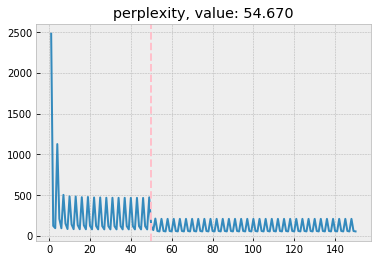

In [177]:
plot_score(model, 'perplexity', 'value', collection1_passes)

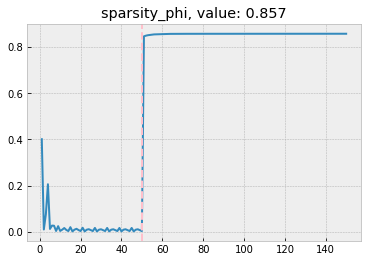

In [178]:
plot_score(model, 'sparsity_phi', 'value', collection1_passes)

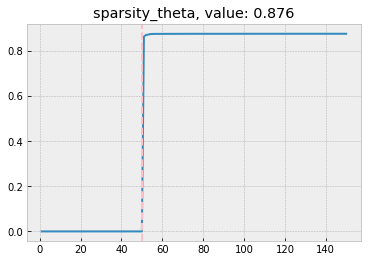

In [179]:
plot_score(model, 'sparsity_theta', 'value', collection1_passes)

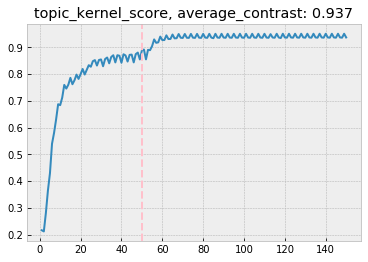

In [180]:
plot_score(model, 'topic_kernel_score', 'average_contrast', collection1_passes)

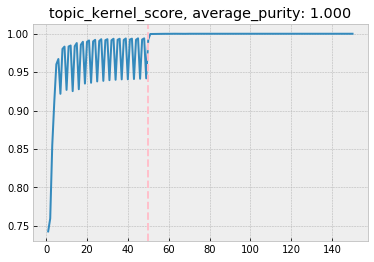

In [181]:
plot_score(model, 'topic_kernel_score', 'average_purity', collection1_passes)

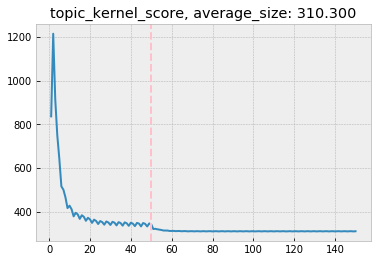

In [182]:
plot_score(model, 'topic_kernel_score', 'average_size', collection1_passes)

### Тестирование на размеченных данных

In [183]:
data3 = pd.read_excel('Добавление в комманду список .xlsx')
data3 = data3[['Суть вопроса','Информация от инициатора','Процесс']]
data3['Суть вопроса'] = data3['Суть вопроса'].fillna('')
data3['Процесс'] = data3['Процесс'].fillna('')
data3['text'] = data3['Суть вопроса'] + ' ' + data3['Информация от инициатора']
data3['text'] = data3['text'].apply(lambda x: ' '.join(x.split()))
data3['Процесс'] = data3['Процесс'].apply(lambda x: ' '.join(x.split()))
data3 = data3[['text','Процесс']]
data3.columns = ['text','process']
data3.shape

(1211, 2)

In [184]:
top_topics = {}
saved_top_tokens_txt = model.get_score('top_tokens')
tokens = saved_top_tokens_txt.ListFields()[saved_top_tokens_txt.TOPIC_INDEX_FIELD_NUMBER][1]
topics = saved_top_tokens_txt.ListFields()[saved_top_tokens_txt.NUM_ENTRIES_FIELD_NUMBER][1]
for topic_name, word_iter in groupby(zip(topics, tokens), key=lambda x: x[0]):
    #print('[%9s] ' % topic_name, end='')
    word_string = ' '.join([x[1] for x in word_iter][:8])
    #print(word_string)
    top_topics[topic_name] = word_string

prc = TextProcessor(lemmatize=True, stopwords_files=['russian.txt'], names=names)
index = set(phi.index)

def get_top_topics(text):
    text = prc.convert(text)
    text = bigram_transformer(text)
    words = text.split()
    c = Counter(words)
    for x in text.split():
        if x not in index:
            del c[x]

    nwd, vocabl = np.zeros((len(c), 1), dtype=int), {}
    for i, (term, cnt) in enumerate(c.items()):
        nwd[i, 0] = cnt
        vocabl[i] = term
    bv = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=nwd, vocabulary=vocabl)
    teta = model.transform(bv)
    print('-' * 80)
    for x in teta[teta['0'] > 0].sort_values('0', ascending=False).itertuples():
        #print('[{:>5s} {:.6f}] => {}'.format(x[0], x[1], top_topics[x[0]]))
        print('[{:15s} {:.6f}]'.format(x[0], x[1]))

In [238]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Подробная информация от инициатора.. 5902179267 ООО "Кайрос Инжиниринг" добавить в карточку организации Кредитный инспектор Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.535311]
[Прочее          0.333110]
[Тема 6          0.131579]


In [239]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Просьба добавить КИ Носова А. А. в организацияю ООО "Серебряный Саквояж" ID 1-OAI5P Просьба добавить КИ Носова А. А. в организацияю ООО "Серебряный Саквояж" ID 1-OAI5P Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.886364]
[Тема 2          0.113636]


In [240]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Добрый день! В связи с замещением сотрудника просьба добавить в карточку организации СИБЭКО (ИНН 5405270340). Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.621663]
[Прочее          0.283463]
[Смена ВКО       0.094873]


In [241]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Включите меня пожалуйста в карточку организации ООО "АДС-Инвест" с ролью "Сотрудник ПМ". ИНН: 3006007350 (ID: 1-2KMPDB) Включите меня пожалуйста в карточку организации ООО "АДС-Инвест" с ролью "Сотрудник ПМ". ИНН: 3006007350 (ID: 1-2KMPDB) Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.541550]
[Прочее          0.398210]
[Тема 4          0.060241]


In [242]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить в карточку орг. в CRM, Власов Андрей Константинович <Vlasov-AK@mail.ca.sbrf.ru> с ролью участник ООО БИЛ инн 2306001245 1-52OMKB Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Прошу добавить в карточку орг. в CRM, Власов Андрей Константинович <Vlasov-AK@mail.ca.sbrf.ru> с ролью участник ООО БИЛ инн 2306001245 1-52OMKB Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.448398]
[Смена ВКО       0.410052]
[Прочее          0.098815]
[Тема 0          0.042735]


In [243]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Необходимо добавить Фрадкину Юлию Валерьевну в карточку организции 1-DDRQLB Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.730912]
[Прочее          0.184856]
[Задачи          0.084232]


In [244]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Необходимо добавить меня в карточку по следующим клиентам: ИП Скотдаев (1-23Q1FN3) ИП Старшинов (1-7B1AEL) ИП Куперчак (1-62HWEF) ИП Рекуненко (1-9249VXG) ООО СтройБат (1-9JF3WT) Необходимо добавить меня в карточку по следующим клиентам: ИП Скотдаев (1-23Q1FN3) ИП Старшинов (1-7B1AEL) ИП Куперчак (1-62HWEF) ИП Рекуненко (1-9249VXG) ООО СтройБат (1-9JF3WT) Нестандартный ЗНО
--------------------------------------------------------------------------------
[Тема 0          0.339806]
[Прочее          0.338100]
[Задачи          0.225007]
[Тема 2          0.048544]
[Тема 5          0.048544]


In [245]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить меня с ролью «Сотрудник ПМ» и моего руководителя – Федорову Н.В. с ролью «Руководитель ПМ» в карточку организации. Клиентский менеджер отсутствует. Прошу добавить меня с ролью «Сотрудник ПМ» и моего руководителя – Федорову Н.В. с ролью «Руководитель ПМ» в карточку организации. Клиентский менеджер отсутствует. Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.429325]
[Прочее          0.264552]
[Тема 2          0.153061]
[Тема 1          0.051020]
[Тема 3          0.051020]
[Тема 6          0.051020]


In [246]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить сотрудника Ощенко Дмитрия Александровича в карточку организации ООО Агротех-Гарант (ID 1-DEBVL), с ролью "кредитный специалист". Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.554570]
[Прочее          0.329151]
[Тема 2          0.116279]


In [247]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Добрый день! В карточке организации 1-1ZN1ZM Заемщика ОАО Яргортеплоэнерго просьба присвоить роль сотруднику подразделения андеррайтинга Свалухину Алексею Анатольевичу роль "участник команды" Добрый день! В карточке организации 1-1ZN1ZM Заемщика ОАО Яргортеплоэнерго просьба присвоить роль сотруднику подразделения андеррайтинга Свалухину Алексею Анатольевичу роль "участник команды" Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.531956]
[Прочее          0.259335]
[Тема 2          0.166336]
[Тема 3          0.042373]


In [248]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Включение в карточку СРМ Прошу включить в карточку организации ООО Компания Лига 7 Сотрудник - Толмачева Ольга Николаевна Роль - сотрудник ПМ / участник от под. мониторинга Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.401754]
[Прочее          0.382790]
[Тема 6          0.074627]
[Тема 2          0.073526]
[Смена ВКО       0.067303]


In [249]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Добрый день! Просьба добавить меня в карточку организации 1-RLRRM3 ООО РБГ с ролью кредитный специалист Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.566415]
[Задачи          0.236896]
[Прочее          0.147322]
[Тема 2          0.049367]


In [250]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить в карточку организации (Территория) Администрация городского поселения Менделеево (ИНН 5044051026)двух сотрудников РМ: 1. Шабалин Дмитрий Леонидович с ролью "Сотрудник ПМ" 2. Зотова Ирина Борисовна с ролью "Руководитель ПМ" Прошу добавить в карточку организации Администрация городского поселения Менделеево (ИНН 5044051026)двух сотрудников РМ: 1. Шабалин Дмитрий Леонидович с ролью "Сотрудник ПМ" 2. Зотова Ирина Борисовна с ролью "Руководитель ПМ" С уважением, Мазитова Елена ОМКО №10 (УРМ г.Ярославль) УМКОиЗО Среднерусского банка ПАО Сбербанк вн. 5860-1226 Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.425509]
[Тема 1          0.153097]
[Прочее          0.145664]
[Тема 5          0.092593]
[Тема 2          0.091981]
[Смена ВКО       0.060292]
[Тема 3          0.030864]


In [251]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу вернуть в работу некоррктно закрытую сделку 1-LF39BQ3 ИП Свиридов Прошу вернуть в работу некоррктно закрытую сделку 1-LF39BQ3 ИП Свиридов Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.591837]
[Тема 4          0.306122]
[Тема 0          0.102041]


In [252]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

просьба включить меня в карточку организации по клиентам ИНН 612902060967 614300087316 611800696977 Нестандартный ЗНО
--------------------------------------------------------------------------------
[Прочее          0.672465]
[Задачи          0.327535]


In [253]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

В рамках последующего контроля простых сделок прошу добавить: 1-2GA2PMC - карточка организации 1-J2TMD43 - карточка сделки Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.498997]
[Задачи          0.222448]
[Прочее          0.191470]
[Тема 2          0.051546]
[Тема 3          0.035538]


In [254]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Добавление в Одну карточку организации (во вложении) с ролью сотрудник КП. Срочно. Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.670535]
[Задачи          0.166028]
[Прочее          0.163437]


In [255]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Коллеги, добрый день. Понимаю, что вы отказываете по подобным заявкам, но у нас безвыходная ситуация. Большая просьба, добавьте пожалуйста в карточку организации 5405352955 СТРОИТЕЛЬНЫЙ КОНЦЕРН "МЕТАПРИБОР" сотрудника Кондратьев Максим Евгеньевич, таб. 858978 с возможностью размещения документов в ЭКД. Доступ необходим в целях отображения результатов мониторинга заложенного в банке имущества в досье клиента. Спасибо. см. суть вопроса Нестандартный ЗНО
--------------------------------------------------------------------------------
[Тема 2          0.239140]
[Тема 6          0.176056]
[Задачи          0.155645]
[Прочее          0.143708]
[Тема 5          0.140845]
[Смена ВКО       0.109394]
[Тема 3          0.035211]


In [256]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу включить в карточку организации ID 1-KECE77G кредитного аналитика Рипп Эллу Олеговну, с ролью - кредитный специалист Прошу включить в карточку организации ID 1-KECE77G кредитного аналитика Рипп Эллу Олеговну, с ролью - кредитный специалист Нестандартный ЗНО
--------------------------------------------------------------------------------
[Прочее          0.662162]
[Тема 2          0.337838]


In [257]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

ПРОШУ ДОБАВИТЬ КАРТОЧКИ ДЛЯ ДОСТУПА В CRM ДЛЯ РАБОТЫ В КОМАНДЕ. Роль -участник команды . Нет клиентского менеджера. В командировке. Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.729795]
[Задачи          0.151732]
[Прочее          0.064126]
[Тема 5          0.054348]


In [258]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

прошу исключить меня из организации т.к я перестала с ними работать ИНН 5031111246 ID 1-5MQ8JIQ ИНН 5033008854 ID 1-JFC55 Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.703809]
[Задачи          0.209928]
[Прочее          0.086263]


In [259]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить в карточку организации 1-7E1V9W с ролью сотрудник КП Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.627587]
[Прочее          0.372413]


In [260]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Просьба по Клиенту 1-1UP0PBM ТРОПИК ИНТЕРНЕШНЛ добавить в СРМ в: 1. карточку организации 1-1UP0PBM ТРОПИК ИНТЕРНЕШНЛ; 2. карточку сделки 1-J1EMT11; 3. карточку договора 01220017/55011100АСР; 4. карточку договора 01230017/55011100АСР; следующих сотрудников: Полунина Я.В. - сотрудник ПМ, Лопатина Н.В. - руководитель ПМ. Нестандартный ЗНО
--------------------------------------------------------------------------------
[Прочее          0.439138]
[Задачи          0.368554]
[Тема 2          0.192308]


In [261]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Добрый день! Просьба добавить в КО ООО ДИАКОН-М 1-CM0D9U, ИНН 7727751059, андеррайтера Корневу Ирину Николаевну Добрый день! Просьба добавить в КО ООО ДИАКОН-М 1-CM0D9U, ИНН 7727751059, андеррайтера Корневу Ирину Николаевну Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.875650]
[Смена ВКО       0.124350]


In [262]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить Попова Василия Юрьевича в карточку организации 1-E5T0G с ролью сотрудник ПМ и Афанасьева Дениса Геннадьевича как руководитель ПМ Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.558036]
[Прочее          0.332240]
[Смена ВКО       0.109724]


In [263]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу включить меня в карточку организации Ходалов Евгений Николаевич ИНН 290200847069 номер организации 1-ET4BZE Нестандартный ЗНО
--------------------------------------------------------------------------------
[Прочее          0.812769]
[Задачи          0.187231]


In [264]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Добрый день. Прошу добавить АР Ванина Виктора Васильевича в карточку организации для отработки критериев. ООО Золотовское ИНН: 6132007148 ID карточки: 1-49IVI2 КМ, на данный момент, отсутствует на рабочем месте. Добрый день. Прошу добавить АР Ванина Виктора Васильевича в карточку организации для отработки критериев. ООО Золотовское ИНН: 6132007148 ID карточки: 1-49IVI2 КМ, на данный момент, отсутствует на рабочем месте. Нестандартный ЗНО
--------------------------------------------------------------------------------
[Прочее          0.383628]
[Задачи          0.301686]
[Тема 6          0.244755]
[Тема 2          0.034965]
[Тема 3          0.034965]


In [265]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

ВКС сделки 1-JTHHC56 назначить Лимонова Юлия Сергеевна Добавить в команду организации1-D4YPRY- КМ Лимонова Юлия Сергеевна Согласовано с Региональным менеджером( во вложении) Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.772884]
[Прочее          0.155950]
[Задачи          0.071166]


In [266]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить меня в карточку мониторинга ПА 1-2VA9P9C ИНН клиента: 6623077877 Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен калинина Наталья Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.599682]
[Прочее          0.238334]
[Задачи          0.161985]


In [267]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

ДД, просьба включить в команду КО 1-F8121TM КА Зорину Марию Андреевну с ролью главный кредитный специалист в связи с работой по кредитной сделке. Спасибо. ДД, просьба включить в команду КО 1-F8121TM КА Зорину Марию Андреевну с ролью главный кредитный специалист в связи с работой по кредитной сделке. Спасибо. Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.362736]
[Тема 2          0.240901]
[Смена ВКО       0.208862]
[Тема 1          0.048544]
[Тема 4          0.048544]
[Тема 6          0.048544]
[Тема 5          0.041870]


In [268]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Добавить в команду с ролью КМ Почекутова Марина Николаевна Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен С уважением, Остапов Василий Александрович Ассистент клиентского менеджера управления продаж крупному и среднему бизнесу Автозаводского головного отделения (на правах управления) Поволжского банка ПАО Сбербанк Тел. раб.: (8482)71-83-38 (вн.3107) e-mail: Ostapov.Va.Al@omega.sbrf.ru vaostapov@sberbank.ru Адрес офиса: г.Тольятти, ул.Юбилейная,55, каб.210 Режим работы: пн.-чет. с 8-00 до 17-00, пт. с 8-00 до 16-00 перерыв 13-00 до 13-45 сб., вс. выходной Нестандартный ЗНО
--------------------------------------------------------------------------------
[Тема 1          0.476800]
[Смена ВКО       0.311102]
[Тема 3          0.053192]
[Тема 6          0.052404]
[Тема 2          0.044018]
[Прочее          0.033178]
[Тема 0          0.029307]


In [269]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить меня в команду с ролью - сотрудник КП Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.783341]
[Задачи          0.216659]


In [270]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить меня в карточки организации с ролью "Сотрудник ПМ" и карточки проблемности с ролью "Сотрудник КП" (с передачей мне лидерства) следующих клиентов: ООО "АМКК" (ИНН 2302041078) ООО "Юг-Вино" (ИНН 0105047528) ООО "Молтранс" (ИНН 2353022570) ООО СМП "Тур" (ИНН 1511013442) ЗАО "АПК Геленджик" (ИНН 2304042422) ООО "Макшел-КМВ" (ИНН 2632065430) Прошу добавить меня в карточки организации с ролью "Сотрудник ПМ" и карточки проблемности с ролью "Сотрудник КП" (с передачей мне лидерства) следующих клиентов: ООО "АМКК" (ИНН 2302041078) ООО "Юг-Вино" (ИНН 0105047528) ООО "Молтранс" (ИНН 2353022570) ООО СМП "Тур" (ИНН 1511013442) ЗАО "АПК Геленджик" (ИНН 2304042422) ООО "Макшел-КМВ" (ИНН 2632065430) Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.692146]
[Прочее          0.148844]
[Тема 2          0.088339]
[Тема 5          0.053004]
[Тема 6          0.017668]


In [271]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу включить меня в команду в карточку организации ИП Демитров Сергей Владимирович ИНН 660307153650 Нестандартный ЗНО
--------------------------------------------------------------------------------
[Прочее          0.466904]
[Смена ВКО       0.295689]
[Задачи          0.237407]


In [272]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить в карточку организации НАУЧНО-ПРОИЗВОДСТВЕННАЯ КОРПОРАЦИЯ УРАЛВАГОНЗАВОД ИМ Ф.Э. ДЗЕРЖИНСКОГО ИНН 6623029538 АР Дьякова Светлана Николаевна. ВКО находится в командировке и сам добавить не может. Прошу добавить в карточку организации НАУЧНО-ПРОИЗВОДСТВЕННАЯ КОРПОРАЦИЯ УРАЛВАГОНЗАВОД ИМ Ф.Э. ДЗЕРЖИНСКОГО ИНН 6623029538 АР Дьякова Светлана Николаевна. Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.411687]
[Прочее          0.304222]
[Тема 6          0.170455]
[Тема 2          0.056818]
[Тема 3          0.056818]


In [273]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Необходимо включить в карточку орг-и АО "Сбербанк Лизинг" с ролью "участник" Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.621190]
[Прочее          0.229756]
[Задачи          0.149055]


In [274]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить кредитного инспектора подразделения мониторинга в карточку организации Полунину Яну Валерьевну Тульская гармонь (7105023801) Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.638588]
[Задачи          0.157435]
[Прочее          0.149020]
[Тема 3          0.054956]


In [275]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить в карточку организации ООО УЗРМВ "АКВА-ВАЙТ" (ИНН 2626029850) с ролью сотрудник ПМ. Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.522286]
[Задачи          0.351142]
[Прочее          0.126572]


In [276]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Добавить в карточку организации c ролью Андеррайтер Челахян Феликс Сергеевич Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.695753]
[Задачи          0.153114]
[Прочее          0.151134]


In [277]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Просьба добавить в организацию ООО "ГраСС-М" ID 1-5V9S35K для возможности добавлять в ЭКД Документы по новым Договорам Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.570255]
[Тема 2          0.310154]
[Прочее          0.119592]


In [278]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу добавить сотрудника КП Новиков Константин Александрович в карточку организации ООО "БЕЛЭНЕРГОМАШ-БЗЭМ" ИНН 3123315768 ID 1-1X33GC2 Прошу добавить сотрудника КП Новиков Константин Александрович в карточку организации ООО "БЕЛЭНЕРГОМАШ-БЗЭМ" ИНН 3123315768 ID 1-1X33GC2 Нестандартный ЗНО
--------------------------------------------------------------------------------
[Задачи          0.683351]
[Прочее          0.316649]


In [279]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Прошу закрепить организацию за КМ Ермоленко Татьяна Андреевна с ролью Клиентский менеджер и добавить в команду АКМ Лукина Эльвира Николаевна, АКМ Мироханова Анна Николаевн с ролью участник команды Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.626677]
[Прочее          0.161953]
[Тема 2          0.080500]
[Задачи          0.073398]
[Тема 3          0.057471]


In [280]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Просьба включить в карточку мониторинга ПА организации: ООО ХардМеталл (ИНН 7453208553) Галимову Ларису Владимировну и Богданову Ольгу Павловну для контроля необходимости приостановления выдачи средств в рамках договора овердрафта в случае выявления критериев «красной»/ «черной» зоны до момента утверждения их влияния/ не влияния на зону проблемности Нестандартный ЗНО
--------------------------------------------------------------------------------
[Тема 3          0.266030]
[Прочее          0.262995]
[Задачи          0.202159]
[Тема 6          0.161290]
[Тема 2          0.107527]


In [281]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Включение в карточку ГСЗ с ролью "Сотрудник ПМ" Содержание запроса (включая вложенные файлы) доступно только работнику банка, на которого он назначен Нестандартный ЗНО
--------------------------------------------------------------------------------
[Смена ВКО       0.730067]
[Задачи          0.188269]
[Прочее          0.081664]


In [282]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

День добрый. Прошу включить меня: Камышанский Александр Викторович (учётная запись в территориальном банке: Западно-Уральский Банк) в карточку организации с ролью Сотрудник ПМ. ID карточки организации 1-224YTP НИВА С уважением, Камышанский Александр Кредитный инспектор Отдел мониторинга кредитных операций № 9 Управление мониторинга кредитных операций и залогового обеспечения ПАО Сбербанк, Волго-Вятский банк Внутр.тел.: 8-5649-8480 Гор.тел.: 8(342)2185780. Россия, г. Пермь, ул. Куйбышева, д. 66/1, 4 этаж kamyshansky.al.vi@omega.sbrf.ru День добрый. Прошу включить меня: Камышанский Александр Викторович (учётная запись в территориальном банке: Западно-Уральский Банк) в карточку организации с ролью Сотрудник ПМ. ID карточки организации 1-224YTP НИВА С уважением, Камышанский Александр Кредитный инспектор Отдел мониторинга кредитных операций № 9 Управление мониторинга кредитных операций и залогового обеспечения ПАО Сбербанк, Волго-Вятский банк Внутр.тел.: 8-5649-8480; Гор.тел.: 8(342)2185780

In [283]:
test_text = data3.sample(1).text.values[0]
print(test_text)
get_top_topics(test_text)

Коллеги, добрый день. Понимаю, что вы отказываете по подобным заявкам, но у нас безвыходная ситуация. Большая просьба, добавьте пожалуйста в карточку организации 5405352955 СТРОИТЕЛЬНЫЙ КОНЦЕРН "МЕТАПРИБОР" сотрудника Кондратьев Максим Евгеньевич, таб. 858978 с возможностью размещения документов в ЭКД. Доступ необходим в целях отображения результатов мониторинга заложенного в банке имущества в досье клиента. Спасибо. см. суть вопроса Нестандартный ЗНО
--------------------------------------------------------------------------------
[Тема 2          0.239140]
[Тема 6          0.176056]
[Задачи          0.155645]
[Прочее          0.143708]
[Тема 5          0.140845]
[Смена ВКО       0.109394]
[Тема 3          0.035211]
